In [1]:
import os
#os.system('pwd')

import torch
import torchhd
from torchhd.models import Centroid
from torchhd import embeddings
import torchvision
from torchvision.datasets import MNIST
from torchhd.datasets.isolet import ISOLET
from torchhd.datasets import EMGHandGestures
#from torch_geometric.datasets import TUDataset
import torchmetrics
from tqdm import tqdm
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import random
import json
import math
import seaborn as sns

from scipy.interpolate import make_interp_spline
from openpyxl import load_workbook
import matplotlib.colors as mcolors
from scipy.ndimage import gaussian_filter1d
from torchmetrics.classification import MulticlassAccuracy
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import pandas as pd
import quant_models
from torch.utils.data import DataLoader, TensorDataset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using {} device".format(device))

BATCH_SIZE = 1

Using cpu device


In [ ]:
# faults in CHV

class Encoder_rand(nn.Module):
    def __init__(self, out_features, size, levels):
        super(Encoder_rand, self).__init__()
        #self.flatten = torch.nn.Flatten(start_dim=-2)
        self.project = embeddings.Sinusoid(size, out_features)
        self.name="RandomProjectionEncoder"
    
    def forward(self, x):
        #x = self.flatten(x)
        sample_hv = self.project(x)
        #sample_hv = torchhd.multiset(sample_hv)
        return torchhd.hard_quantize(sample_hv)

###### =====================================BASE LEVEL=============================================

class Encoder_base(nn.Module):
    def __init__(self, out_features, size, levels):
        super(Encoder_base, self).__init__()
        #self.flatten = torch.nn.Flatten(start_dim=-2)
        self.position = embeddings.Random(size, out_features)
        self.value = embeddings.Level(levels, out_features)
        self.name="BaseLevelEncoder"

    def forward(self, x):
        #x = self.flatten(x)
        sample_hv = torchhd.bind(self.position.weight, self.value(x))
        sample_hv = torchhd.multiset(sample_hv)
        return torchhd.hard_quantize(sample_hv)

def inject_fault(input_weight, amount):
    """
    Injects faults into a binary tensor (with bits == 1).
    
    Args:
        input_weight (torch.Tensor): The input weight tensor to modify (binary values: -1 or +1).
        amount (int): Number of faults to inject.

    Returns:
        torch.Tensor: Modified tensor with injected faults.
    """
    rng = np.random.default_rng()

    # Clone and flatten the weight data
    weight_data = input_weight.clone()
    rows, cols = weight_data.shape
    flat_weights = F.relu(weight_data).type(torch.int).flatten()

    # Convert -1/+1 to 0/1 (binary representation)
    binary_weights = (flat_weights + 1) // 2

    # Randomly select bit indices to flip
    fault_indices = rng.choice(binary_weights.numel(), amount, replace=False)

    # Flip the bits
    binary_weights[fault_indices] = 1 - binary_weights[fault_indices]

    # Convert back to -1/+1 representation
    modified_weights = binary_weights * 2 - 1
    faulty_weights = modified_weights.reshape(rows, cols)

    return faulty_weights 


def CHV_with_correction(faultyclass, faultyECC, normalclass, normalECC, correction):
    num_columns = faultyclass.shape[1]
    finalCHV = normalclass.clone()
    replace_count = 0
    nonrep = 0
    # print(faultyECC[:,0])
    # print(normalECC[:,0])
    print("faultyECC num", (faultyECC != normalECC).sum(), end = ", ")
    print("faultyclass num", (faultyclass != normalclass).sum(), end = ", ")
    for col in range(num_columns):
        # Merge class and ECC by concatenating their column vectors
        faulty_merged = torch.cat((faultyclass[:, col], faultyECC[:, col]))
        normal_merged = torch.cat((normalclass[:, col], normalECC[:, col]))
        
        diff_count = (faulty_merged != normal_merged).sum().item()
        
        if diff_count > correction: 
            #correction
            finalCHV[:, col] = faultyclass[:, col]
            # # Calculate Hamming distance
            # diff_count = (faulty_merged != normal_merged).sum().item()

            # # If only 1 bit differs, replace with normalclass column
            # if diff_count == 1:
            #     finalCHV[:, col] = normalclass[:, col]
            replace_count += 1
        else:
            nonrep +=1

    print(f"Number of replaced columns: {replace_count}, {nonrep}")
    return finalCHV

def get_accuracy_with_correction(DIMENSION, encoder, quantize, dataset, faults, correction, ecc_bits):
    # Load encoder and weights
    path_prefix = f"./models/{dataset}/{encoder}/"
    path_to_encoder = path_prefix + f"enc_quantize_{quantize}_{DIMENSION}.pt"
    path_to_weights = path_prefix + f"quantize_{quantize}_{DIMENSION}.pt"

    print(path_to_weights, path_to_encoder)


    weights = torch.load(path_to_weights, map_location= torch.device('cpu'))
    encode = torch.load(path_to_encoder, map_location= torch.device('cpu'), weights_only = False)

    num_classes = weights.shape[0]
    model = Centroid(int(DIMENSION), num_classes)
    model.weight.data = weights
    normalECC = torch.ones(ecc_bits, int(DIMENSION))
    # print(weights[:,605])
    # Dataset setup
    transform = torchvision.transforms.ToTensor()
    if dataset == "mnist":
        test_ds = MNIST("./data", train=False, transform=transform, download=True)
    elif dataset == "isolet":
        test_ds = ISOLET("./data", train=False, download=True)
    test_ld = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

    class_fault = int(weights.numel() *faults)
    ECC_fault = int(normalECC.numel() *faults)
    print("---- ", weights.numel(), faults, class_fault, ECC_fault)
    faultyW = inject_fault(weights, class_fault)
    faultyECC = inject_fault(normalECC, ECC_fault)
    model.weight.data = faultyW

    # Accuracy on faulty weights
    accuracy = torchmetrics.Accuracy("multiclass", num_classes=num_classes)
    accuracy.reset()
    for samples, labels in tqdm(test_ld, desc="Testing Faulty", disable=True):
        samples = samples.flatten(start_dim=-2)
        samples_hv = encode(samples)
        outputs = model(samples_hv, dot=True)
        accuracy.update(torch.argmax(outputs.cpu(),dim=-1).flatten(), labels)
    accFaulty = accuracy.compute().item()
    print("accFaulty ", accFaulty)
    # Accuracy after correction fault free ECC
    wCorrected = CHV_with_correction(faultyW, normalECC, weights, normalECC, correction)

    model.weight.data = wCorrected

    accuracy.reset()
    for samples, labels in tqdm(test_ld, desc="Testing Corrected", disable=True):
        samples = samples.flatten(start_dim=-2)
        samples_hv = encode(samples)
        outputs = model(samples_hv, dot=True)
        accuracy.update(torch.argmax(outputs.cpu(),dim=-1).flatten(), labels)
    accWithCorrectionfaultfreeECC = accuracy.compute().item()
    print("accWithCorrectionfaultfreeECC ", accWithCorrectionfaultfreeECC)

    # Accuracy after correction normal memory ECC
    wCorrected = CHV_with_correction(faultyW, faultyECC, weights, normalECC, correction)

    model.weight.data = wCorrected

    accuracy.reset()
    for samples, labels in tqdm(test_ld, desc="Testing Corrected", disable=True):
        samples = samples.flatten(start_dim=-2)
        samples_hv = encode(samples)
        outputs = model(samples_hv, dot=True)
        accuracy.update(torch.argmax(outputs.cpu(),dim=-1).flatten(), labels)
    accWithCorrection = accuracy.compute().item()
    print("accWithCorrection ", accWithCorrection)

    return accFaulty, accWithCorrectionfaultfreeECC, accWithCorrection


def log_run_result(faults, accFaulty, accWithCorrectionfaultfreeECC, accWithCorrection,DIMENSION, encoder, dataset ):
    file_path=f"{DIMENSION}_{encoder}_{dataset}_accuracy_results.json"
    result = {
        "faults": faults,
        "accFaulty": accFaulty,
        "accWithCorrectionfaultfreeECC" : accWithCorrectionfaultfreeECC,
        "accWithCorrection": accWithCorrection
    }

    # Load existing results if the file exists
    # if os.path.exists(file_path):
    #     with open(file_path, "r") as f:
    #         data = json.load(f)
    # else:
    #     data = []

    # data.append(result)

    # Save updated list
    with open(file_path, "w") as f:
        json.dump(result, f, indent=4)


def plot_results(DIMENSION, encoder, dataset):
    file_path=f"{DIMENSION}_{encoder}_{dataset}_accuracy_results.json"
    with open(file_path, "r") as f:
        data = json.load(f)

    faults = [entry["faults"] for entry in data]
    acc_faulty = [entry["accFaulty"] for entry in data]
    acc_corrected = [entry["accWithCorrection"] for entry in data]
    acc_corrected_fault_free_ECC = [entry["accWithCorrectionfaultfreeECC"] for entry in data]

    plt.plot(faults, acc_faulty, label="Faulty Accuracy")
    plt.plot(faults, acc_corrected, label="Accuracy with faulty ECC")
    plt.plot(faults, acc_corrected_fault_free_ECC, label="Accuracy with fault free")
    plt.xlabel("Percentage of Faults")
    plt.ylabel("Accuracy")
    #plt.title("Accuracy vs Number of Faults")
    plt.legend()
    #plt.grid(True)
    # plt.show()
    plt.savefig(f"{DIMENSION}_{encoder}_{dataset}.png")

./models/isolet/BaseLevelEncoder/quantize_1_5000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_5000.pt
Files already downloaded and verified
----  130000 0 0 0


/tmp/ipykernel_754969/167602683.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.8101347088813782
faultyECC num tensor(0), faultyclass num tensor(0), Number of replaced columns: 0, 5000
accWithCorrectionfaultfreeECC  0.8101347088813782
faultyECC num tensor(0), faultyclass num tensor(0), Number of replaced columns: 0, 5000
accWithCorrection  0.8101347088813782
./models/isolet/BaseLevelEncoder/quantize_1_5000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_5000.pt
Files already downloaded and verified
----  130000 0.03 3900 750


/tmp/ipykernel_754969/167602683.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.7703655958175659
faultyECC num tensor(0), faultyclass num tensor(3900), Number of replaced columns: 930, 4070
accWithCorrectionfaultfreeECC  0.7979474067687988
faultyECC num tensor(750), faultyclass num tensor(3900), Number of replaced columns: 1199, 3801
accWithCorrection  0.7934573292732239
./models/isolet/BaseLevelEncoder/quantize_1_5000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_5000.pt
Files already downloaded and verified
----  130000 0.06 7800 1500


/tmp/ipykernel_754969/167602683.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.7568954229354858
faultyECC num tensor(0), faultyclass num tensor(7800), Number of replaced columns: 2308, 2692
accWithCorrectionfaultfreeECC  0.7633098363876343
faultyECC num tensor(1500), faultyclass num tensor(7800), Number of replaced columns: 2791, 2209
accWithCorrection  0.764592707157135
./models/isolet/BaseLevelEncoder/quantize_1_5000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_5000.pt
Files already downloaded and verified
----  130000 0.09 11700 2250


/tmp/ipykernel_754969/167602683.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.6908274292945862
faultyECC num tensor(0), faultyclass num tensor(11700), Number of replaced columns: 3464, 1536
accWithCorrectionfaultfreeECC  0.7030147314071655
faultyECC num tensor(2250), faultyclass num tensor(11700), Number of replaced columns: 3920, 1080
accWithCorrection  0.7010904550552368
./models/isolet/BaseLevelEncoder/quantize_1_5000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_5000.pt
Files already downloaded and verified
----  130000 0.12 15600 3000


/tmp/ipykernel_754969/167602683.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.6812059283256531
faultyECC num tensor(0), faultyclass num tensor(15600), Number of replaced columns: 4213, 787
accWithCorrectionfaultfreeECC  0.6856959462165833
faultyECC num tensor(3000), faultyclass num tensor(15600), Number of replaced columns: 4502, 498
accWithCorrection  0.6856959462165833
./models/isolet/BaseLevelEncoder/quantize_1_5000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_5000.pt
Files already downloaded and verified
----  130000 0.15 19500 3750


/tmp/ipykernel_754969/167602683.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.6799229979515076
faultyECC num tensor(0), faultyclass num tensor(19500), Number of replaced columns: 4582, 418
accWithCorrectionfaultfreeECC  0.6824887990951538
faultyECC num tensor(3750), faultyclass num tensor(19500), Number of replaced columns: 4788, 212
accWithCorrection  0.6837716698646545
./models/isolet/BaseLevelEncoder/quantize_1_5000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_5000.pt
Files already downloaded and verified
----  130000 0.18 23400 4500


/tmp/ipykernel_754969/167602683.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.5728030800819397
faultyECC num tensor(0), faultyclass num tensor(23400), Number of replaced columns: 4807, 193
accWithCorrectionfaultfreeECC  0.5779345631599426
faultyECC num tensor(4500), faultyclass num tensor(23400), Number of replaced columns: 4917, 83
accWithCorrection  0.5792174339294434
./models/isolet/BaseLevelEncoder/quantize_1_5000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_5000.pt
Files already downloaded and verified
----  130000 0.21 27300 5250


/tmp/ipykernel_754969/167602683.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.5246953368186951
faultyECC num tensor(0), faultyclass num tensor(27300), Number of replaced columns: 4914, 86
accWithCorrectionfaultfreeECC  0.5349583029747009
faultyECC num tensor(5250), faultyclass num tensor(27300), Number of replaced columns: 4969, 31
accWithCorrection  0.529826819896698
./models/isolet/BaseLevelEncoder/quantize_1_5000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_5000.pt
Files already downloaded and verified
----  130000 0.24 31200 6000


/tmp/ipykernel_754969/167602683.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.49903783202171326
faultyECC num tensor(0), faultyclass num tensor(31200), Number of replaced columns: 4967, 33
accWithCorrectionfaultfreeECC  0.5022450089454651
faultyECC num tensor(6000), faultyclass num tensor(31200), Number of replaced columns: 4986, 14
accWithCorrection  0.4958306550979614
./models/isolet/BaseLevelEncoder/quantize_1_5000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_5000.pt
Files already downloaded and verified
----  130000 0.27 35100 6750


/tmp/ipykernel_754969/167602683.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.4663245677947998
faultyECC num tensor(0), faultyclass num tensor(35100), Number of replaced columns: 4984, 16
accWithCorrectionfaultfreeECC  0.46568313241004944
faultyECC num tensor(6750), faultyclass num tensor(35100), Number of replaced columns: 4997, 3
accWithCorrection  0.46696600317955017
./models/isolet/BaseLevelEncoder/quantize_1_5000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_5000.pt
Files already downloaded and verified
----  130000 0.30000000000000004 39000 7500


/tmp/ipykernel_754969/167602683.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.3559974431991577
faultyECC num tensor(0), faultyclass num tensor(39000), Number of replaced columns: 4991, 9
accWithCorrectionfaultfreeECC  0.354714572429657
faultyECC num tensor(7500), faultyclass num tensor(39000), Number of replaced columns: 4999, 1
accWithCorrection  0.3559974431991577
./models/isolet/BaseLevelEncoder/quantize_1_5000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_5000.pt
Files already downloaded and verified
----  130000 0.33000000000000007 42900 8250


/tmp/ipykernel_754969/167602683.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.26427197456359863
faultyECC num tensor(0), faultyclass num tensor(42900), Number of replaced columns: 4998, 2
accWithCorrectionfaultfreeECC  0.26363053917884827
faultyECC num tensor(8250), faultyclass num tensor(42900), Number of replaced columns: 5000, 0
accWithCorrection  0.26427197456359863
./models/isolet/BaseLevelEncoder/quantize_1_10000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_10000.pt
Files already downloaded and verified
----  260000 0 0 0


/tmp/ipykernel_754969/167602683.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.8242462873458862
faultyECC num tensor(0), faultyclass num tensor(0), Number of replaced columns: 0, 10000
accWithCorrectionfaultfreeECC  0.8242462873458862
faultyECC num tensor(0), faultyclass num tensor(0), Number of replaced columns: 0, 10000
accWithCorrection  0.8242462873458862
./models/isolet/BaseLevelEncoder/quantize_1_10000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_10000.pt
Files already downloaded and verified
----  260000 0.03 7800 1500


/tmp/ipykernel_754969/167602683.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.7998716831207275
faultyECC num tensor(0), faultyclass num tensor(7800), Number of replaced columns: 1823, 8177
accWithCorrectionfaultfreeECC  0.8159076571464539
faultyECC num tensor(1500), faultyclass num tensor(7800), Number of replaced columns: 2373, 7627
accWithCorrection  0.8127004504203796
./models/isolet/BaseLevelEncoder/quantize_1_10000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_10000.pt
Files already downloaded and verified
----  260000 0.06 15600 3000


/tmp/ipykernel_754969/167602683.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.7761385440826416
faultyECC num tensor(0), faultyclass num tensor(15600), Number of replaced columns: 4687, 5313
accWithCorrectionfaultfreeECC  0.801154613494873
faultyECC num tensor(3000), faultyclass num tensor(15600), Number of replaced columns: 5630, 4370
accWithCorrection  0.7979474067687988
./models/isolet/BaseLevelEncoder/quantize_1_10000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_10000.pt
Files already downloaded and verified
----  260000 0.09 23400 4500


/tmp/ipykernel_754969/167602683.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.7671584486961365
faultyECC num tensor(0), faultyclass num tensor(23400), Number of replaced columns: 6927, 3073
accWithCorrectionfaultfreeECC  0.7761385440826416
faultyECC num tensor(4500), faultyclass num tensor(23400), Number of replaced columns: 7821, 2179
accWithCorrection  0.7722899317741394
./models/isolet/BaseLevelEncoder/quantize_1_10000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_10000.pt
Files already downloaded and verified
----  260000 0.12 31200 6000


/tmp/ipykernel_754969/167602683.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.6927517652511597
faultyECC num tensor(0), faultyclass num tensor(31200), Number of replaced columns: 8367, 1633
accWithCorrectionfaultfreeECC  0.7017318606376648
faultyECC num tensor(6000), faultyclass num tensor(31200), Number of replaced columns: 9052, 948
accWithCorrection  0.6921103000640869
./models/isolet/BaseLevelEncoder/quantize_1_10000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_10000.pt
Files already downloaded and verified
----  260000 0.15 39000 7500


/tmp/ipykernel_754969/167602683.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.7036561965942383
faultyECC num tensor(0), faultyclass num tensor(39000), Number of replaced columns: 9203, 797
accWithCorrectionfaultfreeECC  0.7036561965942383
faultyECC num tensor(7500), faultyclass num tensor(39000), Number of replaced columns: 9593, 407
accWithCorrection  0.7126362919807434
./models/isolet/BaseLevelEncoder/quantize_1_10000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_10000.pt
Files already downloaded and verified
----  260000 0.18 46800 9000


/tmp/ipykernel_754969/167602683.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.7068634033203125
faultyECC num tensor(0), faultyclass num tensor(46800), Number of replaced columns: 9620, 380
accWithCorrectionfaultfreeECC  0.7017318606376648
faultyECC num tensor(9000), faultyclass num tensor(46800), Number of replaced columns: 9845, 155
accWithCorrection  0.7062219381332397
./models/isolet/BaseLevelEncoder/quantize_1_10000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_10000.pt
Files already downloaded and verified
----  260000 0.21 54600 10500


/tmp/ipykernel_754969/167602683.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.6407954096794128
faultyECC num tensor(0), faultyclass num tensor(54600), Number of replaced columns: 9833, 167
accWithCorrectionfaultfreeECC  0.6440025568008423
faultyECC num tensor(10500), faultyclass num tensor(54600), Number of replaced columns: 9946, 54
accWithCorrection  0.6382296085357666
./models/isolet/BaseLevelEncoder/quantize_1_10000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_10000.pt
Files already downloaded and verified
----  260000 0.24 62400 12000


/tmp/ipykernel_754969/167602683.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.6100063920021057
faultyECC num tensor(0), faultyclass num tensor(62400), Number of replaced columns: 9918, 82
accWithCorrectionfaultfreeECC  0.6055163741111755
faultyECC num tensor(12000), faultyclass num tensor(62400), Number of replaced columns: 9981, 19
accWithCorrection  0.6093649864196777
./models/isolet/BaseLevelEncoder/quantize_1_10000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_10000.pt
Files already downloaded and verified
----  260000 0.27 70200 13500


/tmp/ipykernel_754969/167602683.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.6042335033416748
faultyECC num tensor(0), faultyclass num tensor(70200), Number of replaced columns: 9968, 32
accWithCorrectionfaultfreeECC  0.603592038154602
faultyECC num tensor(13500), faultyclass num tensor(70200), Number of replaced columns: 9989, 11
accWithCorrection  0.603592038154602
./models/isolet/BaseLevelEncoder/quantize_1_10000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_10000.pt
Files already downloaded and verified
----  260000 0.30000000000000004 78000 15000


/tmp/ipykernel_754969/167602683.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.5125080347061157
faultyECC num tensor(0), faultyclass num tensor(78000), Number of replaced columns: 9989, 11
accWithCorrectionfaultfreeECC  0.5144323110580444
faultyECC num tensor(15000), faultyclass num tensor(78000), Number of replaced columns: 9999, 1
accWithCorrection  0.5131494402885437
./models/isolet/BaseLevelEncoder/quantize_1_10000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_10000.pt
Files already downloaded and verified
----  260000 0.33000000000000007 85800 16500


/tmp/ipykernel_754969/167602683.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.4361770451068878
faultyECC num tensor(0), faultyclass num tensor(85800), Number of replaced columns: 9997, 3
accWithCorrectionfaultfreeECC  0.4361770451068878
faultyECC num tensor(16500), faultyclass num tensor(85800), Number of replaced columns: 10000, 0
accWithCorrection  0.4361770451068878
./models/mnist/BaseLevelEncoder/quantize_1_5000.pt ./models/mnist/BaseLevelEncoder/enc_quantize_1_5000.pt
----  50000 0 0 0
accFaulty  0.7857999801635742
faultyECC num tensor(0), faultyclass num tensor(0), Number of replaced columns: 0, 5000
accWithCorrectionfaultfreeECC  0.7857999801635742
faultyECC num tensor(0), faultyclass num tensor(0), Number of replaced columns: 0, 5000
accWithCorrection  0.7857999801635742
./models/mnist/BaseLevelEncoder/quantize_1_5000.pt ./models/mnist/BaseLevelEncoder/enc_quantize_1_5000.pt
----  50000 0.03 1500 750
accFaulty  0.7580999732017517
faultyECC num tensor(0), faultyclass num tensor(1500), Number of replaced columns: 161, 4839
accWithCorrectionfau

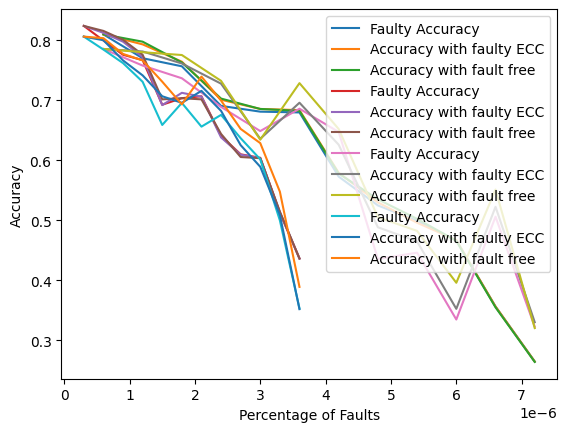

In [ ]:
DIMENSION = ['5000', '10000']
encoders = [ 'BaseLevelEncoder'] # 'BaseLevelEncoder',
datasets = ['isolet', 'mnist']
font_size = 20
 
for encoder in encoders:
    for data in datasets:
        for d in DIMENSION:
            accuracies = []
            if d == 'isolet':
                correction = 2
                ecc_bits = 10
            else:
                correction = 1
                ecc_bits = 5
            # for correction in range(1,3):
            faults = 0
            while faults < 0.35:
                counterReplace = 0
                counterExchange = 0
                # print(faults, end=" : ")
                accFaulty, accWithCorrectionfaultfreeECC, accWithCorrection = get_accuracy_with_correction(d, encoder, '1',  data, faults, correction, ecc_bits)
                faults = faults + 0.03
                accuracies.append(faults/(int(d)*10), accFaulty, accWithCorrectionfaultfreeECC, accWithCorrection)    
            log_run_result(accuracies, d, encoder, data)
            plot_results(d, encoder, data)

In [5]:
# faults in base vectors

class Encoder_rand(nn.Module):
    def __init__(self, out_features, size, levels):
        super(Encoder_rand, self).__init__()
        #self.flatten = torch.nn.Flatten(start_dim=-2)
        self.project = embeddings.Sinusoid(size, out_features)
        self.name="RandomProjectionEncoder"
    
    def forward(self, x):
        #x = self.flatten(x)
        sample_hv = self.project(x)
        #sample_hv = torchhd.multiset(sample_hv)
        return torchhd.hard_quantize(sample_hv)

###### =====================================BASE LEVEL=============================================

class Encoder_base(nn.Module):
    def __init__(self, out_features, size, levels):
        super(Encoder_base, self).__init__()
        #self.flatten = torch.nn.Flatten(start_dim=-2)
        self.position = embeddings.Random(size, out_features)
        self.value = embeddings.Level(levels, out_features)
        self.name="BaseLevelEncoder"

    def forward(self, x):
        #x = self.flatten(x)
        sample_hv = torchhd.bind(self.position.weight, self.value(x))
        sample_hv = torchhd.multiset(sample_hv)
        return torchhd.hard_quantize(sample_hv)

def inject_fault(input_weight, amount):
    """
    Injects faults into a binary tensor (with bits == 1).
    
    Args:
        input_weight (torch.Tensor): The input weight tensor to modify (binary values: -1 or +1).
        amount (int): Number of faults to inject.

    Returns:
        torch.Tensor: Modified tensor with injected faults.
    """
    rng = np.random.default_rng()

    # Clone and flatten the weight data
    weight_data = input_weight.clone()
    rows, cols = weight_data.shape
    flat_weights = F.relu(weight_data).type(torch.int).flatten()

    # Convert -1/+1 to 0/1 (binary representation)
    binary_weights = (flat_weights + 1) // 2

    # Randomly select bit indices to flip
    fault_indices = rng.choice(binary_weights.numel(), amount, replace=False)

    # Flip the bits
    binary_weights[fault_indices] = 1 - binary_weights[fault_indices]

    # Convert back to -1/+1 representation
    modified_weights = binary_weights * 2 - 1
    faulty_weights = modified_weights.reshape(rows, cols)

    return faulty_weights 

def get_accuracy_with_correction(DIMENSION, encoder, quantize, dataset, faults, correction, ecc_bits):
    # Load encoder and weights
    path_prefix = f"./models/{dataset}/{encoder}/"
    path_to_encoder = path_prefix + f"enc_quantize_{quantize}_{DIMENSION}.pt"
    path_to_weights = path_prefix + f"quantize_{quantize}_{DIMENSION}.pt"

    print(path_to_weights, path_to_encoder)


    weights = torch.load(path_to_weights, map_location= torch.device('cpu'))
    encode = torch.load(path_to_encoder, map_location= torch.device('cpu'), weights_only = False)
    print(encode)

    position_fault = int(encode.position.weight.data.numel() *faults)
    value_fault = int(encode.value.weight.data.numel() *faults)
    encode.position.weight.data =  inject_fault(encode.position.weight.data, position_fault)
    # print(encode.position.weight.data[:1], encode.value.weight.data[:1])
    encode.value.weight.data =  inject_fault(encode.value.weight.data, value_fault)
    num_classes = weights.shape[0]
    model = Centroid(int(DIMENSION), num_classes)
    model.weight.data = weights
    normalECC = torch.ones(ecc_bits, int(DIMENSION))
    # print(weights[:,605])
    # Dataset setup
    transform = torchvision.transforms.ToTensor()
    if dataset == "mnist":
        test_ds = MNIST("./data", train=False, transform=transform, download=True)
    elif dataset == "isolet":
        test_ds = ISOLET("./data", train=False, download=True)
    test_ld = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

    
    # Accuracy on faulty weights
    accuracy = torchmetrics.Accuracy("multiclass", num_classes=num_classes)
    accuracy.reset()
    for samples, labels in tqdm(test_ld, desc="Testing Faulty", disable=True):
        samples = samples.flatten(start_dim=-2)
        samples_hv = encode(samples)
        outputs = model(samples_hv, dot=True)
        accuracy.update(torch.argmax(outputs.cpu(),dim=-1).flatten(), labels)
    accFaulty = accuracy.compute().item()
    print("accFaulty ", accFaulty)

    return accFaulty


def log_run_result(faults, accFaulty, DIMENSION, encoder, dataset ):
    file_path=f"{DIMENSION}_{encoder}_{dataset}_accuracy_encoder_results.json"
    result = {
        "faults": faults,
        "accFaulty": accFaulty
        
    }

    # Load existing results if the file exists
    if os.path.exists(file_path):
        with open(file_path, "r") as f:
            data = json.load(f)
    else:
        data = []

    data.append(result)

    # Save updated list
    with open(file_path, "w") as f:
        json.dump(data, f, indent=4)


def plot_results(DIMENSION, encoder, dataset):
    file_path=f"{DIMENSION}_{encoder}_{dataset}_accuracy_encoder_results.json"
    with open(file_path, "r") as f:
        data = json.load(f)

    faults = [entry["faults"] for entry in data]
    acc_faulty = [entry["accFaulty"] for entry in data]
    
    plt.plot(faults, acc_faulty, label="Faulty Accuracy")
    plt.xlabel("Percentage of Faults")
    plt.ylabel("Accuracy")
    #plt.title("Accuracy vs Number of Faults")
    plt.legend()
    #plt.grid(True)
    # plt.show()
    plt.savefig(f"{DIMENSION}_{encoder}_{dataset}_encoder.png")

5000 BaseLevelEncoder 1 isolet 0 1 5
./models/isolet/BaseLevelEncoder/quantize_1_5000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_5000.pt
Encoder_base(
  (position): Random(617, 5000)
  (value): Level(100, 5000)
)
Files already downloaded and verified


/tmp/ipykernel_754969/775703220.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.8101347088813782
5000 BaseLevelEncoder 1 isolet 0.03 1 5
./models/isolet/BaseLevelEncoder/quantize_1_5000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_5000.pt
Encoder_base(
  (position): Random(617, 5000)
  (value): Level(100, 5000)
)
Files already downloaded and verified


/tmp/ipykernel_754969/775703220.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.8005131483078003
5000 BaseLevelEncoder 1 isolet 0.06 1 5
./models/isolet/BaseLevelEncoder/quantize_1_5000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_5000.pt
Encoder_base(
  (position): Random(617, 5000)
  (value): Level(100, 5000)
)
Files already downloaded and verified


/tmp/ipykernel_754969/775703220.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.7742142677307129
5000 BaseLevelEncoder 1 isolet 0.09 1 5
./models/isolet/BaseLevelEncoder/quantize_1_5000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_5000.pt
Encoder_base(
  (position): Random(617, 5000)
  (value): Level(100, 5000)
)
Files already downloaded and verified


/tmp/ipykernel_754969/775703220.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.7203335762023926
5000 BaseLevelEncoder 1 isolet 0.12 1 5
./models/isolet/BaseLevelEncoder/quantize_1_5000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_5000.pt
Encoder_base(
  (position): Random(617, 5000)
  (value): Level(100, 5000)
)
Files already downloaded and verified


/tmp/ipykernel_754969/775703220.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.7126362919807434
5000 BaseLevelEncoder 1 isolet 0.15 1 5
./models/isolet/BaseLevelEncoder/quantize_1_5000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_5000.pt
Encoder_base(
  (position): Random(617, 5000)
  (value): Level(100, 5000)
)
Files already downloaded and verified


/tmp/ipykernel_754969/775703220.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.6433611512184143
5000 BaseLevelEncoder 1 isolet 0.18 1 5
./models/isolet/BaseLevelEncoder/quantize_1_5000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_5000.pt
Encoder_base(
  (position): Random(617, 5000)
  (value): Level(100, 5000)
)
Files already downloaded and verified


/tmp/ipykernel_754969/775703220.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.5445798635482788
5000 BaseLevelEncoder 1 isolet 0.21 1 5
./models/isolet/BaseLevelEncoder/quantize_1_5000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_5000.pt
Encoder_base(
  (position): Random(617, 5000)
  (value): Level(100, 5000)
)
Files already downloaded and verified


/tmp/ipykernel_754969/775703220.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.4939063489437103
5000 BaseLevelEncoder 1 isolet 0.24 1 5
./models/isolet/BaseLevelEncoder/quantize_1_5000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_5000.pt
Encoder_base(
  (position): Random(617, 5000)
  (value): Level(100, 5000)
)
Files already downloaded and verified


/tmp/ipykernel_754969/775703220.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.4457985758781433
5000 BaseLevelEncoder 1 isolet 0.27 1 5
./models/isolet/BaseLevelEncoder/quantize_1_5000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_5000.pt
Encoder_base(
  (position): Random(617, 5000)
  (value): Level(100, 5000)
)
Files already downloaded and verified


/tmp/ipykernel_754969/775703220.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.3264913260936737
5000 BaseLevelEncoder 1 isolet 0.30000000000000004 1 5
./models/isolet/BaseLevelEncoder/quantize_1_5000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_5000.pt
Encoder_base(
  (position): Random(617, 5000)
  (value): Level(100, 5000)
)
Files already downloaded and verified


/tmp/ipykernel_754969/775703220.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.2257857620716095
5000 BaseLevelEncoder 1 isolet 0.33000000000000007 1 5
./models/isolet/BaseLevelEncoder/quantize_1_5000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_5000.pt
Encoder_base(
  (position): Random(617, 5000)
  (value): Level(100, 5000)
)
Files already downloaded and verified


/tmp/ipykernel_754969/775703220.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.17126363515853882
10000 BaseLevelEncoder 1 isolet 0 1 5
./models/isolet/BaseLevelEncoder/quantize_1_10000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_10000.pt
Encoder_base(
  (position): Random(617, 10000)
  (value): Level(100, 10000)
)
Files already downloaded and verified


/tmp/ipykernel_754969/775703220.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.8242462873458862
10000 BaseLevelEncoder 1 isolet 0.03 1 5
./models/isolet/BaseLevelEncoder/quantize_1_10000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_10000.pt
Encoder_base(
  (position): Random(617, 10000)
  (value): Level(100, 10000)
)
Files already downloaded and verified


/tmp/ipykernel_754969/775703220.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.820397675037384
10000 BaseLevelEncoder 1 isolet 0.06 1 5
./models/isolet/BaseLevelEncoder/quantize_1_10000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_10000.pt
Encoder_base(
  (position): Random(617, 10000)
  (value): Level(100, 10000)
)
Files already downloaded and verified


/tmp/ipykernel_754969/775703220.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.7921744585037231
10000 BaseLevelEncoder 1 isolet 0.09 1 5
./models/isolet/BaseLevelEncoder/quantize_1_10000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_10000.pt
Encoder_base(
  (position): Random(617, 10000)
  (value): Level(100, 10000)
)
Files already downloaded and verified


/tmp/ipykernel_754969/775703220.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.787684440612793
10000 BaseLevelEncoder 1 isolet 0.12 1 5
./models/isolet/BaseLevelEncoder/quantize_1_10000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_10000.pt
Encoder_base(
  (position): Random(617, 10000)
  (value): Level(100, 10000)
)
Files already downloaded and verified


/tmp/ipykernel_754969/775703220.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.742142379283905
10000 BaseLevelEncoder 1 isolet 0.15 1 5
./models/isolet/BaseLevelEncoder/quantize_1_10000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_10000.pt
Encoder_base(
  (position): Random(617, 10000)
  (value): Level(100, 10000)
)
Files already downloaded and verified


/tmp/ipykernel_754969/775703220.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.7177677750587463
10000 BaseLevelEncoder 1 isolet 0.18 1 5
./models/isolet/BaseLevelEncoder/quantize_1_10000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_10000.pt
Encoder_base(
  (position): Random(617, 10000)
  (value): Level(100, 10000)
)
Files already downloaded and verified


/tmp/ipykernel_754969/775703220.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.6812059283256531
10000 BaseLevelEncoder 1 isolet 0.21 1 5
./models/isolet/BaseLevelEncoder/quantize_1_10000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_10000.pt
Encoder_base(
  (position): Random(617, 10000)
  (value): Level(100, 10000)
)
Files already downloaded and verified


/tmp/ipykernel_754969/775703220.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.6221936941146851
10000 BaseLevelEncoder 1 isolet 0.24 1 5
./models/isolet/BaseLevelEncoder/quantize_1_10000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_10000.pt
Encoder_base(
  (position): Random(617, 10000)
  (value): Level(100, 10000)
)
Files already downloaded and verified


/tmp/ipykernel_754969/775703220.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.5169980525970459
10000 BaseLevelEncoder 1 isolet 0.27 1 5
./models/isolet/BaseLevelEncoder/quantize_1_10000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_10000.pt
Encoder_base(
  (position): Random(617, 10000)
  (value): Level(100, 10000)
)
Files already downloaded and verified


/tmp/ipykernel_754969/775703220.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.37588196992874146
10000 BaseLevelEncoder 1 isolet 0.30000000000000004 1 5
./models/isolet/BaseLevelEncoder/quantize_1_10000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_10000.pt
Encoder_base(
  (position): Random(617, 10000)
  (value): Level(100, 10000)
)
Files already downloaded and verified


/tmp/ipykernel_754969/775703220.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.37331622838974
10000 BaseLevelEncoder 1 isolet 0.33000000000000007 1 5
./models/isolet/BaseLevelEncoder/quantize_1_10000.pt ./models/isolet/BaseLevelEncoder/enc_quantize_1_10000.pt
Encoder_base(
  (position): Random(617, 10000)
  (value): Level(100, 10000)
)
Files already downloaded and verified


/tmp/ipykernel_754969/775703220.py:30: DeprecationWarning: torchhd.hard_quantize is deprecated, consider using torchhd.normalize instead.
  return torchhd.hard_quantize(sample_hv)


accFaulty  0.2745349705219269
5000 BaseLevelEncoder 1 mnist 0 1 5
./models/mnist/BaseLevelEncoder/quantize_1_5000.pt ./models/mnist/BaseLevelEncoder/enc_quantize_1_5000.pt
Encoder_base(
  (position): Random(784, 5000)
  (value): Level(256, 5000)
)
accFaulty  0.7857999801635742
5000 BaseLevelEncoder 1 mnist 0.03 1 5
./models/mnist/BaseLevelEncoder/quantize_1_5000.pt ./models/mnist/BaseLevelEncoder/enc_quantize_1_5000.pt
Encoder_base(
  (position): Random(784, 5000)
  (value): Level(256, 5000)
)
accFaulty  0.7710000276565552
5000 BaseLevelEncoder 1 mnist 0.06 1 5
./models/mnist/BaseLevelEncoder/quantize_1_5000.pt ./models/mnist/BaseLevelEncoder/enc_quantize_1_5000.pt
Encoder_base(
  (position): Random(784, 5000)
  (value): Level(256, 5000)
)
accFaulty  0.754800021648407
5000 BaseLevelEncoder 1 mnist 0.09 1 5
./models/mnist/BaseLevelEncoder/quantize_1_5000.pt ./models/mnist/BaseLevelEncoder/enc_quantize_1_5000.pt
Encoder_base(
  (position): Random(784, 5000)
  (value): Level(256, 5000)
)


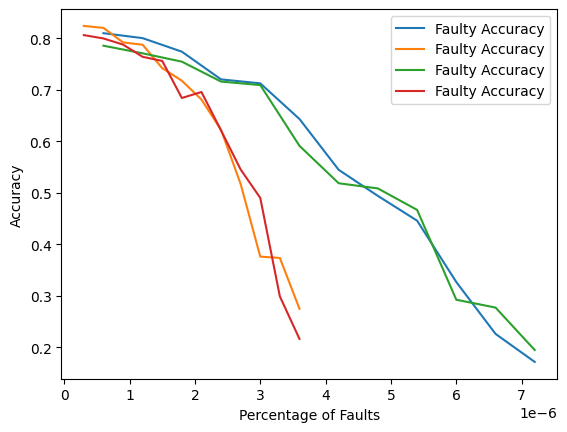

In [6]:
DIMENSION = ['5000', '10000']
encoders = [ 'BaseLevelEncoder'] # 'BaseLevelEncoder',
datasets = ['isolet', 'mnist']
font_size = 20
 
for encoder in encoders:
    for data in datasets:
        for d in DIMENSION:
            if d == 'isolet':
                correction = 2
                ecc_bits = 10
            else:
                correction = 1
                ecc_bits = 5
            # for correction in range(1,3):
            faults = 0
            while faults < 0.35:
                counterReplace = 0
                counterExchange = 0
                # print(faults, end=" : ")
                print(d, encoder, '1',  data, faults, correction, ecc_bits)
                accFaulty = get_accuracy_with_correction(d, encoder, '1',  data, faults, correction, ecc_bits)
                faults = faults + 0.03
                log_run_result(faults/(int(d)*10), accFaulty, d, encoder, data)
            plot_results(d, encoder, data)

In [7]:
def convert_mif_to_vhdl_module(mif_path, number_of_classes = 5, output_path="trans_CHV_mem_10000.vhdl"):
    with open(mif_path, 'r') as file:
        lines = file.readlines()

    # Flatten data lines, remove commas and newlines
    data = ''.join(lines).replace(',', '').replace('\n', '')
    data_chunks = [data[i:i+number_of_classes] for i in range(0, len(data), number_of_classes)]  # 8-bit words

    address_width = (len(data_chunks) - 1).bit_length()
    entity_name = mif_path[:-4]
    output_path=entity_name+".vhdl"
    with open(output_path, 'w') as vhdl_file:
        vhdl_file.write(f"library IEEE;\nuse IEEE.STD_LOGIC_1164.ALL;\nuse IEEE.STD_LOGIC_UNSIGNED.ALL;\n\n")
        vhdl_file.write(f"entity {entity_name} is\n")
        vhdl_file.write(f"    Port (\n")
        vhdl_file.write(f"        clk     : in  STD_LOGIC;\n")
        vhdl_file.write(f"        address : in  STD_LOGIC_VECTOR({address_width - 1} downto 0);\n")
        vhdl_file.write(f"        data    : out STD_LOGIC_VECTOR({number_of_classes} downto 0)\n")
        vhdl_file.write(f"    );\n")
        vhdl_file.write(f"end {entity_name};\n\n")

        vhdl_file.write(f"architecture Behavioral of {entity_name} is\n")
        vhdl_file.write(f"begin\n")
        vhdl_file.write(f"    process(clk)\n")
        vhdl_file.write(f"    begin\n")
        vhdl_file.write(f"        if rising_edge(clk) then\n")
        vhdl_file.write(f"            case address is\n")
        for i, word in enumerate(data_chunks):
            vhdl_file.write(f"                when x\"{i:02X}\" => data <= \"{word}\";\n")
        vhdl_file.write(f"                when others => data <= (others => '0');\n")
        vhdl_file.write(f"            end case;\n")
        vhdl_file.write(f"        end if;\n")
        vhdl_file.write(f"    end process;\n")
        vhdl_file.write(f"end Behavioral;\n")

    print(f"Complete VHDL ROM module written to {output_path}")
# mif_to_vhdl_case.py

convert_mif_to_vhdl_module("MNIST_ECC_CHVs/ECC_CHV_img_10000.mif")


Complete VHDL ROM module written to MNIST_ECC_CHVs/ECC_CHV_img_10000.vhdl


In [ ]:
DIMENSION = [1000, 5000, 10000]

quantize = [1, 8]

encoders = ["RandomProjectionEncoder", "BaseLevelEncoder"]

averaging = [0,10]

In [ ]:
#ISOLET

# DIMENSIONS = 5000  # number of hypervector dimensions
NUM_LEVELS = 100


train_ds = ISOLET("data/", train=True, download=False)
train_ld = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

test_ds = ISOLET("data/", train=False, download=False)
test_ld = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

num_classes = len(train_ds.classes)

for d in DIMENSION:
    for q in quantize:
        for Encoder in encoders:
            
            model, encode, accuracy = train_model(Encoder,
                                        NUM_LEVELS,
                                        d,
                                        train_ds[0][0].size(-1),
                                        num_classes,
                                        q,
                                        "isolet",
                                        train_ld,
                                        test_ld)

            #inject fault
            print("quantize_"+str(q)+"_"+str(d))
            print(f"Testing accuracy of {(accuracy.compute().item() * 100):.3f}%")
            w = model.weight.data.detach().clone()
            
            for avg in range(averaging[0], averaging[1]):
                df = pd.DataFrame(columns=[
                'Fault %', 'Accuracy'
                ])
                faultyPoints = 0

                while faultyPoints < d*num_classes*q:
                    
                    accuracies = []
                    dotsim = []
                    dotsim10 = []
                    classification = []
                    model_faulty = Centroid(d, num_classes)
                    model_faulty = model_faulty.to(device)
                    model_faulty.weight.data = w.clone()
                    
                    model_faulty.weight.data = inject_fault(model_faulty, amount=faultyPoints, bits=q).to(device)

                    accuracy = torchmetrics.Accuracy("multiclass", num_classes=num_classes)
                    with torch.no_grad():
                        # model.normalize(quantize = q)
                        for samples, labels in tqdm(test_ld, desc="Testing", disable= True):
                            samples = samples.to(device)
                            samples_hv = encode(samples)
                            outputs = model_faulty(samples_hv, dot=True)
                            accuracy.update(outputs.cpu(), labels)
                            dotsim.extend(torch.max(outputs.cpu(),dim=1).values.tolist())
                            dotsim10.extend(np.sort(outputs.cpu().detach().numpy()))
                            classification.extend(torch.argmax(outputs.cpu(),dim=1).tolist())
                    
                    dotsimbase = np.array(dotsim)
                    dotsimbase10 = np.array(dotsim10) 
                    classification = np.array(classification)

                    np.save("./models/isolet/" + encode.name + "/faulty/" + "quantize_"+str(q)+"_"+str(d)+"_"+str(avg)+"_"+"dotsimbase10"+".npy", dotsimbase10)
                    np.save("./models/isolet/" + encode.name + "/faulty/" + "quantize_"+str(q)+"_"+str(d)+"_"+str(avg)+"_"+"dotsimbase"+".npy", dotsimbase)
                    np.save("./models/isolet/" + encode.name + "/faulty/" + "quantize_"+str(q)+"_"+str(d)+"_"+str(avg)+"_"+"classified"+".npy", classification)

                    row = {
                            'Fault %': [faultyPoints/(d*num_classes*q)],
                            'Accuracy': [accuracy.compute().item() * 100],
                        }
                    faultyPoints = int(faultyPoints + (d*num_classes*q)/100)
                    row = pd.DataFrame.from_dict(row)
                    df = pd.concat([df,row], ignore_index=True)
                print(df)
                df.to_excel("./models/isolet/" + encode.name + "/faulty/quantize_"+str(q)+"_"+str(d)+"_"+str(avg)+"result.xlsx", index=False)               
        

In [ ]:
#UCI_HAR_Dataset

# Paths to the dataset
train_data_path = 'data/UCI_HAR_Dataset/train/X_train.txt'
train_labels_path = 'data/UCI_HAR_Dataset/train/y_train.txt'
test_data_path = 'data/UCI_HAR_Dataset/test/X_test.txt'
test_labels_path = 'data/UCI_HAR_Dataset/test/y_test.txt'

# Load the dataset
train_data = pd.read_csv(train_data_path, delim_whitespace=True, header=None)
train_labels = pd.read_csv(train_labels_path, delim_whitespace=True, header=None)
test_data = pd.read_csv(test_data_path, delim_whitespace=True, header=None)
test_labels = pd.read_csv(test_labels_path, delim_whitespace=True, header=None)

# Convert data to PyTorch tensors
train_data_tensor = torch.tensor(train_data.values, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values.squeeze(), dtype=torch.long) - 1
test_data_tensor = torch.tensor(test_data.values, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels.values.squeeze(), dtype=torch.long) - 1

# Create TensorDatasets
train_dataset = TensorDataset(train_data_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor)

# Create DataLoaders
train_ld = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_ld = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

NUM_LEVELS = 1000
IMG_SIZE = 561
num_classes = 7 #len(train_loader.classes)
print(num_classes)

for d in DIMENSION:
    for q in quantize:
        for Encoder in encoders:

            model, encode, accuracy = train_model(Encoder,
                                        NUM_LEVELS,
                                        d,
                                        IMG_SIZE,
                                        num_classes,
                                        q,
                                        "ucihar",
                                        train_ld,
                                        test_ld)
            
            print("quantize_"+str(q)+"_"+str(d))
            print(f"Testing accuracy of {(accuracy.compute().item() * 100):.3f}%")

            w = model.weight.data.detach().clone()
            for avg in range(averaging[0], averaging[1]):
                df = pd.DataFrame(columns=[
                'Fault %', 'Accuracy'
                ])
                faultyPoints = 0
                
                while faultyPoints < d*num_classes*q:
                    
                    accuracies = []
                    dotsim = []
                    dotsim10 = []
                    classification = []
                    model_faulty = Centroid(d, num_classes)
                    model_faulty = model_faulty.to(device)
                    model_faulty.weight.data = w.clone()
                    
                    model_faulty.weight.data = inject_fault(model_faulty, amount=faultyPoints, bits=q).to(device)

                    accuracy = torchmetrics.Accuracy("multiclass", num_classes=num_classes)
                    with torch.no_grad():
                        # model.normalize(quantize = q)
                        for samples, labels in tqdm(test_ld, desc="Testing", disable= True):
                            samples = samples.to(device)
                            samples_hv = encode(samples)
                            outputs = model_faulty(samples_hv, dot=True)
                            accuracy.update(outputs.cpu(), labels)
                            dotsim.extend(torch.max(outputs.cpu(),dim=1).values.tolist())
                            dotsim10.extend(np.sort(outputs.cpu().detach().numpy()))
                            classification.extend(torch.argmax(outputs.cpu(),dim=1).tolist())
                    
                    dotsimbase = np.array(dotsim)
                    dotsimbase10 = np.array(dotsim10) 
                    classification = np.array(classification)

                    np.save("./models/ucihar/" + encode.name + "/faulty/" + "quantize_"+str(q)+"_"+str(d)+"_"+str(avg)+"_"+"dotsimbase10"+".npy", dotsimbase10)
                    np.save("./models/ucihar/" + encode.name + "/faulty/" + "quantize_"+str(q)+"_"+str(d)+"_"+str(avg)+"_"+"dotsimbase"+".npy", dotsimbase)
                    np.save("./models/ucihar/" + encode.name + "/faulty/" + "quantize_"+str(q)+"_"+str(d)+"_"+str(avg)+"_"+"classified"+".npy", classification)

                    row = {
                            'Fault %': [faultyPoints/(d*num_classes*q)],
                            'Accuracy': [accuracy.compute().item() * 100],
                        }
                    faultyPoints = int(faultyPoints + (d*num_classes*q)/100)
                    row = pd.DataFrame.from_dict(row)
                    df = pd.concat([df,row], ignore_index=True)
                print(df)
                df.to_excel("./models/ucihar/" + encode.name + "/faulty/quantize_"+str(q)+"_"+str(d)+"_"+str(avg)+"result.xlsx", index=False)               
        

In [ ]:
#MNIST dataset

transform = torchvision.transforms.ToTensor()


train_ds = MNIST("data", train=True, transform=transform, download=True)
train_ld = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_ds = MNIST("data", train=False, transform=transform, download=True)
test_ld = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)



NUM_LEVELS = 256
IMG_SIZE = 28*28
num_classes = 10 

for d in DIMENSION:
    for q in quantize:
        for enc in encoders:
            print("quantize_"+str(q)+"_"+str(d))
            model, encode, accuracy = train_model(enc,
                                        NUM_LEVELS,
                                        d,
                                        IMG_SIZE,
                                        num_classes,
                                        q,
                                        "mnist",
                                        train_ld,
                                        test_ld,
                                        flatten=True,runs=10)
            
            print(f"Testing accuracy of {(accuracy.compute().item() * 100):.3f}%")

            w = model.weight.data.detach().clone()
            #inject fault
            for avg in range(averaging[0], averaging[1]):
                faultyPoints = 0
                w = model.weight.data.detach().clone()
                df = pd.DataFrame(columns=[
                        'Fault %', 'Accuracy'
                    ])
                while faultyPoints < d*num_classes*q:

                    accuracies = []
                    dotsim = []
                    dotsim10 = []
                    classification = []
                    model_faulty = Centroid(d, num_classes)
                    model_faulty = model_faulty.to(device)
                    model_faulty.weight.data = w.clone()
                    model_faulty.weight.data = inject_fault(model_faulty, amount=faultyPoints, bits=q).to(device)
                    
                    accuracy = torchmetrics.Accuracy("multiclass", num_classes=num_classes)
                    with torch.no_grad():
                        # model.normalize(quantize = q)
                        for samples, labels in tqdm(test_ld, desc="Testing", disable= True):
                            samples = samples.to(device)
                            samples = samples.flatten(start_dim=-2)
                            samples_hv = encode(samples)
                            outputs = model_faulty(samples_hv, dot=True)
                            accuracy.update(torch.argmax(outputs.cpu(),dim=-1).flatten(), labels)
                            dotsim.extend(torch.max(outputs.cpu(),dim=1).values.tolist())
                            dotsim10.extend(np.sort(outputs.cpu().detach().numpy()))
                            classification.extend(torch.argmax(outputs.cpu(),dim=1).tolist())
                    
                    dotsimbase = np.array(dotsim)
                    dotsimbase10 = np.array(dotsim10)
                    classification = np.array(classification)

                    np.save("./models/mnist/" + encode.name + "/faulty/" + "quantize_"+str(q)+"_"+str(d)+"_"+str(avg)+"_"+"dotsimbase10"+".npy", dotsimbase10)
                    np.save("./models/mnist/" + encode.name + "/faulty/" + "quantize_"+str(q)+"_"+str(d)+"_"+str(avg)+"_"+"dotsimbase"+".npy", dotsimbase)
                    np.save("./models/mnist/" + encode.name + "/faulty/" + "quantize_"+str(q)+"_"+str(d)+"_"+str(avg)+"_"+"classified"+".npy", classification)

                    row = {
                            'Fault %': [faultyPoints/(d*num_classes*q)],
                            'Accuracy': [accuracy.compute().item() * 100],
                        }
                    faultyPoints = int(faultyPoints + (d*num_classes*q)/100)
                    row = pd.DataFrame.from_dict(row)
                    df = pd.concat([df,row], ignore_index=True)
                print(df)
                df.to_excel("./models/mnist/" + encode.name + "/faulty/quantize_"+str(q)+"_"+str(d)+"_"+str(avg)+"result.xlsx", index=False)               
        